In [1]:
# # 安装必要的库
# !pip install gym
# !pip install stable-baselines3
#!pip install mplcursors

In [2]:
import numpy as np
import pandas as pd
from IPython.display import display
import requests
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mplcursors
import warnings
import os

In [3]:
#CYS & Panko

# 替换API密钥
api_key = 'e1d6c125a1a3cb5682e428d0c7da0621e6220336922e4103fcbdbd19af8e8bf9'

def get_eth_daily_price(api_key):
    url = 'https://min-api.cryptocompare.com/data/v2/histoday'
    parameters = {
        'fsym': 'ETH',  # 以太坊的符号
        'tsym': 'USD',  # 转换到的货币，这里是美元
        'limit': '2000',  # 获取的数据点数，1000代表从今天起往前查1000天
        'api_key': api_key
    }

    response = requests.get(url, params=parameters)
    data = response.json()

    # 创建一个空的DataFrame
    df = pd.DataFrame(columns=['Time', 'Open', 'High', 'Low', 'Close', 'Vol'])

    if response.status_code == 200 and 'Data' in data and 'Data' in data['Data']:
        # 提取每日价格信息
        daily_prices = data['Data']['Data']
        rows = []  # 创建一个空列表来存储行数据
        for price in daily_prices:
            # 创建一个字典，表示一行数据
            row = {
                'Time': pd.to_datetime(price['time'], unit='s'),
                'Open': price['open'],
                'High': price['high'],
                'Low': price['low'],
                'Close': price['close'],
                'Vol': price['volumefrom']
            }
            rows.append(row)  # 将行数据添加到列表中
        df = pd.concat([df, pd.DataFrame(rows)], ignore_index=True)  # 使用concat来添加数据
    else:
        print("无法获取数据")

    return df

# 调用函数获取以太坊的每日价格数据并存入DataFrame
eth_data = get_eth_daily_price(api_key)

# 输出DataFrame查看结果
print(eth_data)

# 假设eth_daily_price_df是您已有的DataFrame，包含至少两天的以太坊价格数据
# 以下是添加'Change'列的代码

# 计算收盘价的变化
# 使用.shift(1)获取前一天的收盘价
eth_data['Change'] = (eth_data['Close'] - eth_data['Close'].shift(1)) / eth_data['Close'].shift(1)

# 查看结果
print(eth_data)

# GR

# 将日期转换为从1970年1月1日起的天数
eth_data['Time'] = (eth_data['Time'] - pd.Timestamp("1970-01-01")).dt.days

# 转换其余变量为数值型，包括处理带有字符的Vol列和百分比的Change列
def convert_vol(x):
    if isinstance(x, str):
        if 'K' in x:
            return float(x.replace('K', '')) * 1000
        elif 'M' in x:
            return float(x.replace('M', '')) * 1000000
    try:
        return float(x)
    except:
        return None

def convert_percentage(x):
    if isinstance(x, str) and '%' in x:
        return float(x.replace('%', '')) / 100
    try:
        return float(x)
    except:
        return None

eth_data['Vol'] = eth_data['Vol'].apply(convert_vol)
eth_data['Change'] = eth_data['Change'].apply(convert_percentage)

# 将数据按日期从旧到新重新排序
eth_data = eth_data.sort_values(by='Time').reset_index(drop=True)

# 显示转换后的数据
display(eth_data.head())


           Time     Open     High      Low    Close         Vol
0    2018-11-28   110.21   126.71   110.20   122.88  1540641.13
1    2018-11-29   122.83   123.89   117.50   117.76  2363349.32
2    2018-11-30   117.76   114.20   109.62   112.91  2203806.82
3    2018-12-01   112.91   120.68   116.82   118.24  2131624.28
4    2018-12-02   118.25   117.44   115.57   116.24  2046743.48
...         ...      ...      ...      ...      ...         ...
1996 2024-05-16  3033.46  3041.60  2924.04  2945.17   221619.51
1997 2024-05-17  2945.17  3121.45  2933.76  3093.44   237502.45
1998 2024-05-18  3093.44  3147.62  3085.46  3123.72   131838.78
1999 2024-05-19  3123.72  3137.07  3054.06  3070.68   139746.96
2000 2024-05-20  3070.68  3139.78  3048.64  3099.56    89528.49

[2001 rows x 6 columns]
           Time     Open     High      Low    Close         Vol    Change
0    2018-11-28   110.21   126.71   110.20   122.88  1540641.13       NaN
1    2018-11-29   122.83   123.89   117.50   117.76  236334

C:\Users\kybun\AppData\Local\Temp\ipykernel_16872\3544285592.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(rows)], ignore_index=True)  # 使用concat来添加数据


,Time,Open,High,Low,Close,Vol,Change
0,17863,110.21,126.71,110.20,122.88,1540641.13,NaN
1,17864,122.83,123.89,117.50,117.76,2363349.32,-0.041667
2,17865,117.76,114.20,109.62,112.91,2203806.82,-0.041185
3,17866,112.91,120.68,116.82,118.24,2131624.28,0.047206
4,17867,118.25,117.44,115.57,116.24,2046743.48,-0.016915


In [4]:
# GR&CYS

import talib

# EMA - 指数移动平均线
eth_data['EMA_7'] = talib.EMA(eth_data['Close'].values, timeperiod=7)
eth_data['EMA_25'] = talib.EMA(eth_data['Close'].values, timeperiod=25)
eth_data['EMA_99'] = talib.EMA(eth_data['Close'].values, timeperiod=99)

# 布林带
eth_data['upper_band'], eth_data['middle_band'], eth_data['lower_band'] = talib.BBANDS(eth_data['Close'].values,
                                                                                        timeperiod=21,
                                                                                        nbdevup=2,
                                                                                        nbdevdn=2,
                                                                                        matype=0)

# 计算RSI
eth_data['RSI'] = talib.RSI(eth_data['Close'].values, timeperiod=14)

# 计算STOCH
eth_data['slowk'], eth_data['slowd'] = talib.STOCH(eth_data['High'].values,
                                                    eth_data['Low'].values,
                                                    eth_data['Close'].values,
                                                    fastk_period=5,
                                                    slowk_period=3,
                                                    slowk_matype=0,
                                                    slowd_period=3,
                                                    slowd_matype=0)

# 计算MACD
eth_data['MACD'], eth_data['MACD_signal'], eth_data['MACD_hist'] = talib.MACD(eth_data['Close'].values,
                                                                               fastperiod=12,
                                                                               slowperiod=26,
                                                                               signalperiod=9)

# 计算CCI
eth_data['CCI'] = talib.CCI(eth_data['High'].values,
                            eth_data['Low'].values,
                            eth_data['Close'].values,
                            timeperiod=14)

# 计算ATR
eth_data['ATR'] = talib.ATR(eth_data['High'].values,
                            eth_data['Low'].values,
                            eth_data['Close'].values,
                            timeperiod=14)

# 计算ROC
eth_data['ROC'] = talib.ROC(eth_data['Close'].values, timeperiod=10)

# 注意：TA-Lib没有直接提供Ultimate Oscillator的计算。你可能需要使用原始公式或查找其他库。


In [4]:
# GR & CYS

import pandas as pd

def calculate_ultimate_oscillator(eth_data):
    # 确保数据是按日期排序的
    eth_data = eth_data.sort_values(by='Time').reset_index(drop=True)

    # 计算购买压力和真实范围
    eth_data['BP'] = eth_data['Close'] - eth_data[['Low', 'Close']].shift(1).min(axis=1)
    eth_data['TR'] = eth_data[['High', 'Close']].shift(1).max(axis=1) - eth_data[['Low', 'Close']].shift(1).min(axis=1)

    # 初始化UO为0
    UO = pd.Series(0, index=eth_data.index)

    periods = [7, 14, 28]
    weights = [4, 2, 1]

    for period, weight in zip(periods, weights):
        ABP = eth_data['BP'].rolling(window=period).sum()
        ATR = eth_data['TR'].rolling(window=period).sum()
        # 修正：确保分母不为0
        ratio = ABP / ATR
        ratio[ATR == 0] = 0  # 防止除以0的情况
        UO += weight * ratio

    # 计算Ultimate Oscillator
    eth_data['UO'] = UO / sum(weights)

    return eth_data

# 将Ultimate Oscillator值添加到DataFrame中
eth_data = calculate_ultimate_oscillator(eth_data)

# 查看结果
display(eth_data)  # 查看最后几行以确认非NaN值


,Time,Open,High,Low,Close,Vol,Change,EMA_7,EMA_25,EMA_99,...,slowd,MACD,MACD_signal,MACD_hist,CCI,ATR,ROC,BP,TR,UO
0,17841,209.54,219.60,210.14,219.34,1214482.69,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17842,219.34,222.21,216.85,217.44,1358813.93,-0.008662,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.30,9.46,NaN
2,17843,217.48,215.81,211.56,211.69,1108888.00,-0.026444,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.16,5.36,NaN
3,17844,211.69,211.11,208.31,209.52,952706.25,-0.010251,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.04,4.25,NaN
4,17845,209.52,213.13,209.93,212.04,924730.08,0.012027,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.73,2.80,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,19837,3219.78,3293.60,3103.60,3139.10,269991.90,-0.025058,3158.372023,3252.646320,3094.780759,...,84.065948,-79.531760,-85.181451,5.649690,21.020740,194.579862,-0.606663,-14.56,111.40,0.626787
1997,19838,3139.10,3191.65,3072.07,3155.47,281066.14,0.005215,3157.646518,3245.171218,3095.994544,...,72.900866,-75.386277,-83.222416,7.836139,19.312519,189.222729,1.690944,51.87,190.00,0.574410
1998,19839,3155.47,3166.44,3101.66,3130.07,219855.93,-0.008050,3150.752388,3236.317278,3096.676053,...,55.511287,-73.305500,-81.239033,7.933533,28.519874,180.333962,1.447129,58.00,119.58,0.587071
1999,19840,3130.07,3281.58,3068.25,3253.23,203602.38,0.039347,3176.371791,3237.618257,3099.807132,...,47.004596,-61.015141,-77.194254,16.179113,97.727805,182.690822,8.981548,151.57,64.78,0.633646


In [5]:
eth_data.dropna(inplace=True)

In [6]:
# GR

# 检查current_price是否为0或负数
invalid_prices = eth_data[eth_data['Close'] <= 0]

# 输出不合理数据的行
print("行中 current_price 不合理的数据：")
print(invalid_prices)


行中 current_price 不合理的数据：
Empty DataFrame
Columns: [Time, Open, High, Low, Close, Vol, Change, EMA_7, EMA_25, EMA_99, upper_band, middle_band, lower_band, RSI, slowk, slowd, MACD, MACD_signal, MACD_hist, CCI, ATR, ROC, BP, TR, UO]
Index: []

[0 rows x 25 columns]


In [7]:
# GR
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

# 假设我们要选择的特征数量是24（可调部分，优化模型时使用）
n_features_to_select = 24

# 初始化模型，这里我们使用随机森林分类器作为示例
model = RandomForestRegressor()

# 初始化RFE对象
rfe = RFE(estimator=model, n_features_to_select=n_features_to_select)

# 这里的features就是你的数据中的特征变量
features = eth_data[['Open', 'High', 'Low', 'Close', 'Vol','EMA_7', 'EMA_25', 'EMA_99',
                                'upper_band', 'middle_band', 'lower_band','RSI', 'slowk', 'slowd', 'MACD', 
                                'MACD_signal', 'MACD_hist', 'CCI', 'ATR', 'ROC', 'BP', 'TR', 'UO']]

# 假设eth_data['target']是你的目标变量
target = eth_data['Change']  # 你需要替换为你的目标变量列名

# 拟合RFE
rfe.fit(features, target)

# 获取选择的特征
selected_features = features.columns[rfe.support_]

# 输出选择的特征
print("Selected features:", selected_features)

Selected features: Index(['Open', 'High', 'Low', 'Close', 'Vol', 'EMA_7', 'EMA_25', 'EMA_99',
       'upper_band', 'middle_band', 'lower_band', 'RSI', 'slowk', 'slowd',
       'MACD', 'MACD_signal', 'MACD_hist', 'CCI', 'ATR', 'ROC', 'BP', 'TR',
       'UO'],
      dtype='object')


In [8]:
# GR

selected_features = ['Open', 'High', 'Low', 'Close', 'Vol','EMA_7', 'EMA_25', 'EMA_99',
                    'upper_band', 'middle_band', 'lower_band','RSI', 'slowk', 'slowd', 'MACD', 
                    'MACD_signal', 'MACD_hist', 'CCI', 'ATR', 'ROC', 'BP', 'TR', 'UO']

# 移除'Change'，因为它是目标变量
feature_columns = [feature for feature in selected_features if feature != 'Change']

def create_rolling_window(data, window_size=5):
    X = []
    y = []
    for i in range(len(data) - window_size):
        # 仅使用已选择的特征创建滚动窗口
        X.append(data[feature_columns].iloc[i:i+window_size].values.flatten())
        # 使用'Change'作为目标变量
        y.append(data['Change'].iloc[i+window_size])

    return np.array(X), np.array(y)

# 创建滚动窗口特征和目标变量
window_size = 45  # （后续根据模型优化步骤调整）
X, y = create_rolling_window(eth_data, window_size)

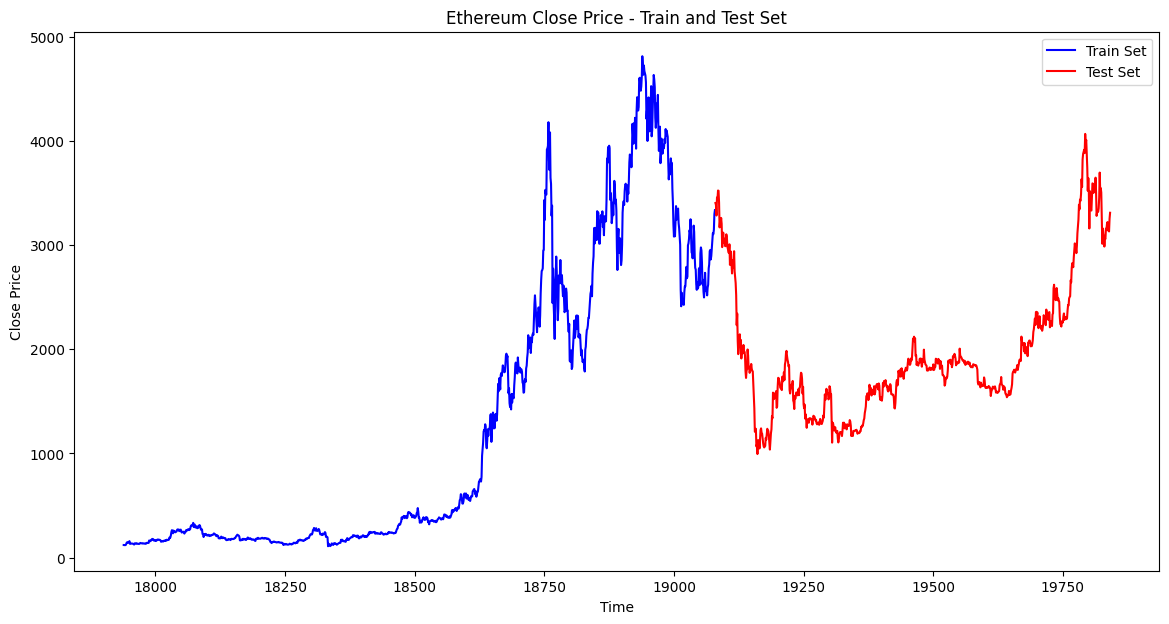

In [9]:
# GR

# 数据集划分已经完成
split_index = int(0.6 * len(eth_data))
train_data = eth_data[:split_index]
test_data = eth_data[split_index:]

# 绘制训练集和测试集的Close价格图
plt.figure(figsize=(14, 7))

# 训练集
plt.plot(train_data['Time'], train_data['Close'], label='Train Set', color='blue')

# 测试集
plt.plot(test_data['Time'], test_data['Close'], label='Test Set', color='red')

plt.title('Ethereum Close Price - Train and Test Set')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [10]:
print(eth_data.isnull().sum())

Time           0
Open           0
High           0
Low            0
Close          0
Vol            0
Change         0
EMA_7          0
EMA_25         0
EMA_99         0
upper_band     0
middle_band    0
lower_band     0
RSI            0
slowk          0
slowd          0
MACD           0
MACD_signal    0
MACD_hist      0
CCI            0
ATR            0
ROC            0
BP             0
TR             0
UO             0
dtype: int64


In [11]:
import gym
from gym import spaces
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

MAX_BALANCE = 2147000000  # 假设的最大账户余额
MAX_NET_WORTH = 2147000000  # 假设的最大净值
MAX_HOLDINGS = 2147000000  # 假设的最大持有数量

class CryptoTradingEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    MAX_BALANCE = 2147000000  # 假设的最大账户余额
    MAX_NET_WORTH = 2147000000  # 假设的最大净值
    MAX_HOLDINGS = 2147000000  # 假设的最大持有数量

    def __init__(self, df, window_size=40, initial_balance=3000):
        super(CryptoTradingEnv, self).__init__()
        self.df_original = df.reset_index(drop=True)
        self.df = self._normalize(df)
        self.window_size = window_size
        self.initial_balance = initial_balance
        self.transaction_fee_percent = 0.01 / 100
        self.min_trade_unit = 0.01
        self.initial_holding_price = 0  # 添加属性来跟踪买入时的价格
        self.action_space = spaces.Box(low=np.array([0, 0]), high=np.array([2, 1]), dtype=np.float32)
        num_features = self.df.shape[1] + 4
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.window_size, num_features), dtype=np.float32)
        self.net_worth_change_history = []  # 用于跟踪净值变化的列表
        self.open_positions = []  # 用于跟踪开仓的列表
        self.close_positions = []  # 用于跟踪平仓的列表
        self.cumulative_returns = 1 


        self.reset()

    def _normalize(self, df):
        df_normalized = df.copy()
        columns_to_normalize = ['Open', 'High', 'Low', 'Close', 'Vol', 'Change','EMA_7', 'EMA_25', 'EMA_99',
                                'upper_band', 'middle_band', 'lower_band', 'RSI', 'slowk', 'slowd', 'MACD', 
                                'MACD_signal', 'MACD_hist', 'CCI', 'ATR', 'ROC', 'BP', 'TR', 'UO']
        for column in columns_to_normalize:
            max_value = df[column].max()
            min_value = df[column].min()
            if max_value > min_value:
                df_normalized[column] = (df[column] - min_value) / (max_value - min_value)
            else:
                df_normalized[column] = df[column]
        return df_normalized

    def _next_observation(self):
        market_obs = self.df.iloc[self.current_step:self.current_step + self.window_size].values
        extra_obs = np.array([
            [self.balance / MAX_BALANCE,
             self.holdings / MAX_HOLDINGS,
             self.net_worth / MAX_NET_WORTH,
             self.transaction_fee_percent]
        ])
        if market_obs.ndim > 1:
            extra_obs_repeated = np.repeat(extra_obs, market_obs.shape[0], axis=0)
        else:
            extra_obs_repeated = extra_obs
        full_obs = np.concatenate((market_obs, extra_obs_repeated), axis=1)
        return full_obs

    def _take_action(self, action):
        current_price = self.df_original.loc[self.current_step, "Close"]
        action_type = action[0]
        action_percentage = action[1]
        net_worth_change = self.net_worth - self.previous_net_worth
        self.net_worth_change_history.append(net_worth_change)
        self.previous_net_worth = self.net_worth  # 更新之前的净值
    
        # Calculate the percentage change if holdings exist
        price_change = ((current_price - self.initial_holding_price) / self.initial_holding_price) if hasattr(self, 'initial_holding_price') else 0
    
        if action_type < 2 / 3:
            buy_amount = self.balance * action_percentage
            if buy_amount > 0:
                shares_bought = buy_amount / current_price
                self.balance -= shares_bought * current_price * (1 + self.transaction_fee_percent)
                self.holdings += shares_bought
                self.initial_holding_price = current_price  # Set the buying price
                self.open_positions.append((self.current_step, current_price))  # 记录开仓位置和价格
                self.initial_holding_price = current_price  # 更新买入价格
        elif 2 / 3 <= action_type < 4 / 3:
            # Holding, do nothing
            pass
        else:
            # Check for stop-loss or take-profit conditions
            if price_change <= -0.5 or price_change >= 1:
                # Force sell all holdings if stop-loss or take-profit conditions are met
                shares_sold = self.holdings
                self.close_positions.append((self.current_step, current_price))  # 记录平仓位置和价格
            else:
                shares_sold = min(self.holdings, self.holdings * action_percentage)
            
            self.balance += shares_sold * current_price * (1 - self.transaction_fee_percent)
            self.holdings -= shares_sold
    
        self.balance = min(self.balance, self.MAX_BALANCE)  # 确保不超过最大余额
        self.net_worth = self.balance + self.holdings * current_price
        self.net_worth = min(self.net_worth, self.MAX_NET_WORTH)  # 确保不超过最大净值
        self.net_worth_history.append(self.net_worth)


    def step(self, action):
        self._take_action(action)
        self.current_step += 1
    
        # 计算所有历史回报
        if len(self.net_worth_history) > 1:
            returns = np.diff(self.net_worth_history) / self.net_worth_history[:-1]                         # 使用所有历史数据
            cumulative_returns = np.prod(1 + returns) - 1                                                   # 计算累计回报
            average_return = np.mean(returns) * self.current_step if len(returns) > 0 else 0                # 计算平均回报
            volatility = np.std(returns) * np.sqrt(self.current_step) if len(returns) > 1 else 0            # 计算波动率
            sharpe_ratio = average_return / volatility if volatility != 0 else 0                            # 计算夏普比率
        else:
            cumulative_return, average_return, volatility, sharpe_ratio = 0, 0, 0, 0
    
        # Risk-adjusted metrics
        var = self.calculate_var()
        es = self.calculate_es()
        max_drawdown = self.calculate_max_drawdown()
        sortino_ratio = self.calculate_sortino_ratio()

        #需要做的事情，调整adjust return，添加VaR，ES，Maxdrawdown，添加cumulative return。
        
        # Calculate total return percent
        total_return_percent = (self.net_worth - self.initial_balance) / self.initial_balance * 100
    
        # Loss aversion - more penalty on losses
        loss_aversion_multiplier = 1
        adjusted_return = average_return if average_return > 0 else average_return * loss_aversion_multiplier

        # Define a target return and adjust reward towards stabilizing around this target
        target_return =  500 # your target return percentage
        return_difference = abs(total_return_percent - target_return) if total_return_percent != target_return else 1

    
        # Reward calculation incorporating Sortino ratio and loss aversion
        reward = (adjusted_return + sortino_ratio + sharpe_ratio + cumulative_returns) / return_difference

        # Check if end condition met
        done = self.current_step >= len(self.df) - self.window_size
    
        obs = self._next_observation()
        return obs, reward, done, {}

    def calculate_sortino_ratio(self, target=0):
        returns = np.array(self.net_worth_history[1:]) / np.array(self.net_worth_history[:-1]) - 1
        downside_returns = returns[returns < target]
        expected_return = np.mean(returns)
        downside_deviation = np.sqrt(np.mean(np.square(downside_returns - target))) if len(downside_returns) > 0 else 0
        sortino_ratio = expected_return / downside_deviation if downside_deviation > 0 else 0
        return sortino_ratio


    def calculate_var(self, percentile=5):
        if len(self.net_worth_history) < 2:
            return 0
        net_worth_changes = np.diff(self.net_worth_history)
        var = np.percentile(net_worth_changes, percentile)
        return var

    def calculate_es(self, percentile=5):
        if len(self.net_worth_history) < 2:
            return 0
        net_worth_changes = np.diff(self.net_worth_history)
        var = self.calculate_var(percentile)
        losses_below_var = net_worth_changes[net_worth_changes <= var]
        return np.mean(losses_below_var) if len(losses_below_var) > 0 else 0


    def calculate_max_drawdown(self):
        if not self.net_worth_history:
            return 0
        max_drawdown = 0
        peak = self.net_worth_history[0]
        for net_worth in self.net_worth_history:
            if net_worth > peak:
                peak = net_worth
            drawdown = (peak - net_worth) / peak
            if drawdown > max_drawdown:
                max_drawdown = drawdown
        return max_drawdown

    def reset(self):
        self.balance = self.initial_balance
        self.holdings = 0
        self.net_worth = self.initial_balance
        self.net_worth_history = [self.initial_balance]
        self.initial_holding_price = 0  # Reset the buying price
        self.previous_net_worth = self.initial_balance  # Initialize the previous_net_worth here
        self.current_step = 0
        return self._next_observation()

    def render(self, mode='human', close=False):
        if close:
            return
        plt.figure(figsize=(15, 5))
        plt.plot(self.net_worth_history)
        plt.title('Net Worth Over Time')
        plt.ylabel('Net Worth')
        plt.xlabel('Step')
        plt.show()

In [12]:
# 实例化环境CryptoTradingEnv并从中提取关键参数信息
env = CryptoTradingEnv(eth_data)

# 获取环境的参数信息
state_dim = env.observation_space.shape  # 注意，这里可能返回一个元组，表示多维的观测空间
action_dim = env.action_space.shape  # 同上，对于Box空间，这也可能是一个元组

# 对于Box空间，最大动作值不再是单一值，而是每个维度的上界
max_action = env.action_space.high  # 这将返回一个数组，每个元素对应一个动作维度的最大值

# 获取数据集中的最大步数，适用于你的环境
max_step = len(eth_data) - env.window_size  # 减去窗口大小以适应观测空间的构造

# 打印信息
print(f'State dimensions: {state_dim}, Action dimensions: {action_dim}, Max action value: {max_action}, Max step: {max_step}')


State dimensions: (40, 29), Action dimensions: (2,), Max action value: [2. 1.], Max step: 1863


c:\Users\kybun\.conda\envs\DRL_env\lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [13]:
# 封装与强化学习算法交互的主要方法
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class StockAgent:
    def __init__(self, algorithm):
        self.algorithm = algorithm
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def predict(self, obs):
        try:
            obs = torch.tensor(obs.reshape(1, -1), dtype=torch.float32, device=self.device)
            with torch.no_grad():
                action = self.algorithm.predict(obs)
            action_numpy = action.cpu().numpy()[0]
            return action_numpy
        except Exception as e:
            print(f"An error occurred during prediction: {e}")
            # 返回一个默认动作或错误处理逻辑
            return np.zeros(action.shape)  # 假设这里返回一个全零动作数组

    def sample(self, obs):
        try:
            obs = torch.tensor(obs.reshape(1, -1), dtype=torch.float32, device=self.device)
            with torch.no_grad():
                action = self.algorithm.sample(obs)
            action_numpy = action.cpu().numpy()[0]
            return action_numpy
        except Exception as e:
            print(f"An error occurred during sampling: {e}")
            # 返回一个默认动作或错误处理逻辑
            return np.zeros(action.shape)  # 同上

    def learn(self, obs, action, reward, next_obs, terminal):
        try:
            terminal = np.expand_dims(terminal, axis=-1)
            reward = np.expand_dims(reward, axis=-1)

            obs = torch.tensor(obs, dtype=torch.float32, device=self.device)
            action = torch.tensor(action, dtype=torch.float32, device=self.device)
            reward = torch.tensor(reward, dtype=torch.float32, device=self.device)
            next_obs = torch.tensor(next_obs, dtype=torch.float32, device=self.device)
            terminal = torch.tensor(terminal, dtype=torch.float32, device=self.device)

            critic_loss, actor_loss = self.algorithm.learn(obs, action, reward, next_obs, terminal)
            return critic_loss.item(), actor_loss.item()
        except Exception as e:
            print(f"An error occurred during learning: {e}")
            # 这里可以返回默认的损失值或处理错误
            return 0.0, 0.0  # 假设返回0损失

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

LOG_SIG_MAX = 1.0
LOG_SIG_MIN = -20

class StockModel(nn.Module):
    def __init__(self, obs_dim, action_dim):
        super(StockModel, self).__init__()
        self.actor_model = Actor(obs_dim, action_dim)
        self.critic_model = Critic(obs_dim, action_dim)

    def policy(self, obs):
        return self.actor_model(obs)

    def value(self, obs, action):
        return self.critic_model(obs, action)

    def get_actor_params(self):
        return self.actor_model.parameters()

    def get_critic_params(self):
        return self.critic_model.parameters()

class Critic(nn.Module):
    def __init__(self, obs_dim, action_dim):
        super(Critic, self).__init__()
        flat_obs_dim = np.prod(obs_dim)  # 正确处理可能的多维观察空间
        self.l1 = nn.Linear(flat_obs_dim + action_dim, 256)  # 正确的定义，合并观察和动作维度
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, 1)

        self.l4 = nn.Linear(flat_obs_dim + action_dim, 256)  # 使用flat_obs_dim
        self.l5 = nn.Linear(256, 256)
        self.l6 = nn.Linear(256, 1)

        self.apply(self.init_weights)  # 应用权重初始化

    def forward(self, obs):
        obs = obs.view(obs.size(0), -1)
        x = F.leaky_relu(self.l1(obs), 0.01)  # Using LeakyReLU for a bit more robustness
        x = F.leaky_relu(self.l2(x), 0.01)
        
        act_mean = self.mean_linear(x)
        act_std = self.std_linear(x)
        act_log_std = torch.clamp(act_std, min=LOG_SIG_MIN, max=LOG_SIG_MAX)
        return act_mean, act_log_std

    @staticmethod
    def init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, 0)

In [15]:
SEED = 0  # 随机种子，用于确保实验的可重复性
EVAL_EPISODES = 5  # 评估轮数，即在评估期间运行多少个完整的环境episode
# MEMORY_SIZE 参数对于PPO来说不是必要的，因为PPO直接从最近的经验中学习，并不依赖于大型经验回放池
BATCH_SIZE = 64  # 批次大小，PPO算法在处理每个epoch的数据时使用的样本数量
GAMMA = 0.995  # 折扣因子，用于计算未来奖励的当前价值，对所有强化学习算法都很重要
ACTOR_LR = 1e-4  # actor网络的学习率
CRITIC_LR = 1e-4  # critic网络的学习率，PPO中通常称为value function的学习率
CLIP_PARAM = 0.2  # 剪裁参数，限制策略更新的幅度，这是PPO特有的重要参数
MAX_REWARD = -1e9  # 最大奖励，用于初始化或比较最优奖励值，用于追踪训练过程中的最佳性能
file_name = 'ppo_Crypto'  # 模型保存的名称，反映算法和应用领域

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

# 设定设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.l1 = nn.Linear(np.prod(state_dim), 64)
        self.l2 = nn.Linear(64, 64)
        self.mean = nn.Linear(64, action_dim)
        self.log_std = nn.Linear(64, action_dim)
        self.apply(self.init_weights)
        self.total_step_count = 0  # 初始化步数计数器

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, mean=0., std=0.1)
            nn.init.constant_(m.bias, 0)

    def forward(self, state):
        state = torch.flatten(state, start_dim=1)  # Flatten the state
        x = F.relu(self.l1(state))
        x = F.relu(self.l2(x))
        # 对于动作类型，我们使用tanh函数来获得输出值在[-1, 1]之间
        action_type = torch.tanh(self.mean(x))
        
        # 对于动作百分比，我们可以继续使用sigmoid函数获得输出值在[0, 1]之间
        # 不过，由于这里我们不是输出log_std，而是直接输出action_percentage
        # 所以我们需要改变变量名和使用的激活函数
        action_percentage = torch.sigmoid(self.log_std(x))
    # 返回动作类型和动作百分比
        return action_type, action_percentage
        
class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.l1 = nn.Linear(np.prod(state_dim), 64)
        self.l2 = nn.Linear(64, 64)
        self.l3 = nn.Linear(64, 1)
        self.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, mean=0., std=0.1)
            nn.init.constant_(m.bias, 0)

    def forward(self, state):
        state = torch.flatten(state, start_dim=1)  # Flatten the state
        x = F.relu(self.l1(state))
        x = F.relu(self.l2(x))
        return self.l3(x)

class PPO(nn.Module):
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip):
        super(PPO, self).__init__()
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        self.actor = Actor(state_dim, action_dim).to(device)
        self.critic = Critic(state_dim).to(device)
        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=lr_critic)
        self.MseLoss = nn.MSELoss()
        # 确保这一行在 __init__ 方法中
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # 确保其他使用到 device 的地方位于设置 device 之后
        self.actor = Actor(state_dim, action_dim).to(self.device)
        self.critic = Critic(state_dim).to(self.device)
        # 你需要确保其他方法（如 select_action, update）兼容连续动作空间
        # 并且按照上面Actor和Critic类的修改进行调整。

    def load_weights(self, file_name):
        if os.path.isfile(file_name):
            print("加载模型权重...")
            self.load_state_dict(torch.load(file_name, map_location=self.device))
        else:
            print("未找到模型文件，将从头开始训练。")

    def select_action(self, state, memory):
        state_tensor = torch.FloatTensor(state).reshape(1, -1).to(device)
        mean, log_std = self.actor(state_tensor)
        std = torch.exp(log_std)
        dist = torch.distributions.Normal(mean, std)
        sampled_actions = dist.sample()

        # 添加随机探索来鼓励模型尝试不同的动作
        epsilon = 0.1  # 探索率，可以调整
        if random.random() < epsilon:
            # 随机选择一个动作类型，在完整的动作空间内
            action_type = np.random.uniform(0, 2)
            # 随机选择一个动作百分比，在(0, 1)之间
            action_percentage = np.random.uniform(0, 1)
        else:
            # 使用tanh激活函数得到的输出调整动作类型
            action_type = (torch.tanh(mean[0, 0]) + 1) * (2 / 3)  # 将(-1, 1)调整到(0, 2)
            action_type = action_type.item()
            
            # 动作百分比仍然使用sigmoid激活函数
            action_percentage = torch.sigmoid(mean[0, 1])
            action_percentage = action_percentage.item()

    
        final_action = [action_type, action_percentage]
    
        memory.states.append(state)
        memory.actions.append(final_action)
        memory.logprobs.append(dist.log_prob(sampled_actions).sum().detach().cpu().numpy())
    
        return final_action


    def update(self, memory):
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(memory.rewards), reversed(memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
        
        rewards = torch.tensor(np.array(memory.rewards), dtype=torch.float32, device=self.device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)
        is_terminals = torch.tensor(np.array(memory.is_terminals), dtype=torch.float32, device=self.device)
    
        old_states = torch.stack([torch.tensor(s, dtype=torch.float32, device=self.device) for s in memory.states])
        old_actions = torch.stack([torch.tensor(a, dtype=torch.float32, device=self.device) for a in memory.actions])
        old_logprobs = torch.stack([torch.tensor(lp, dtype=torch.float32, device=self.device) for lp in memory.logprobs])
    
        for _ in range(self.K_epochs):
            logprobs, state_values, dist_entropy = self.evaluate(old_states, old_actions)
            
            # 调整 old_logprobs 的形状
            old_logprobs = old_logprobs.view(logprobs.shape)  # 试图移除最后两个维度，如果它们的大小是1
            
            ratios = torch.exp(logprobs - old_logprobs.detach())
            advantages = rewards - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy
    
            self.optimizer_actor.zero_grad()
            self.optimizer_critic.zero_grad()
            loss.mean().backward()
            self.optimizer_actor.step()
            self.optimizer_critic.step()
        
        memory.clear()

    def evaluate(self, state, action):
        mean, log_std = self.actor(state)
        std = log_std.exp()
        dist = torch.distributions.Normal(mean, std)
        action_logprobs = dist.log_prob(action).sum(axis=-1)
        dist_entropy = dist.entropy().sum(axis=-1)
        state_value = self.critic(state)
        
        return action_logprobs, state_value, dist_entropy


未加载权重，使用初始模型参数。
Episode 0, Final Net Worth: 51890.28052010984, Return: 1629.68%, Return Volatility: 0.047836, Total Rewards: 49.29
Episode 100, Final Net Worth: 55080.4603443665, Return: 1736.02%, Return Volatility: 0.048185, Total Rewards: 20.47
Episode 200, Final Net Worth: 46599.04190510597, Return: 1453.30%, Return Volatility: 0.047861, Total Rewards: 34.47


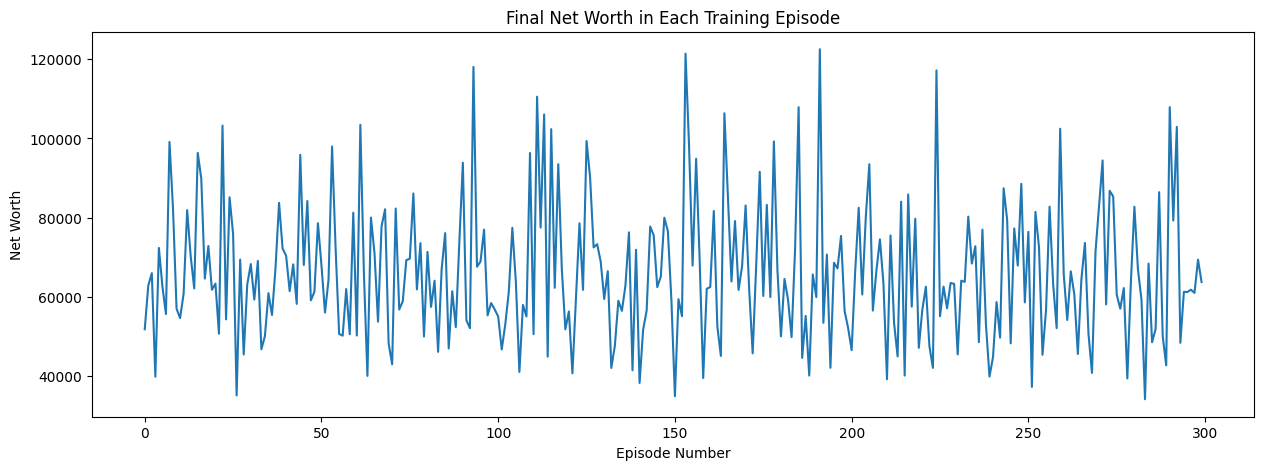

Training completed
Test 0, Final Net Worth: 3472.449716912103, Return: 15.75%, Return Volatility: 0.033591, Total Rewards: -1.27
Test 100, Final Net Worth: 3531.740782816128, Return: 17.72%, Return Volatility: 0.033542, Total Rewards: -1.61
Test 200, Final Net Worth: 2594.992568311058, Return: -13.50%, Return Volatility: 0.034148, Total Rewards: -2.23
Average Test Return: -4.56%
Average Test Volatility: 0.03
Re_Vola Ratio: -1.36


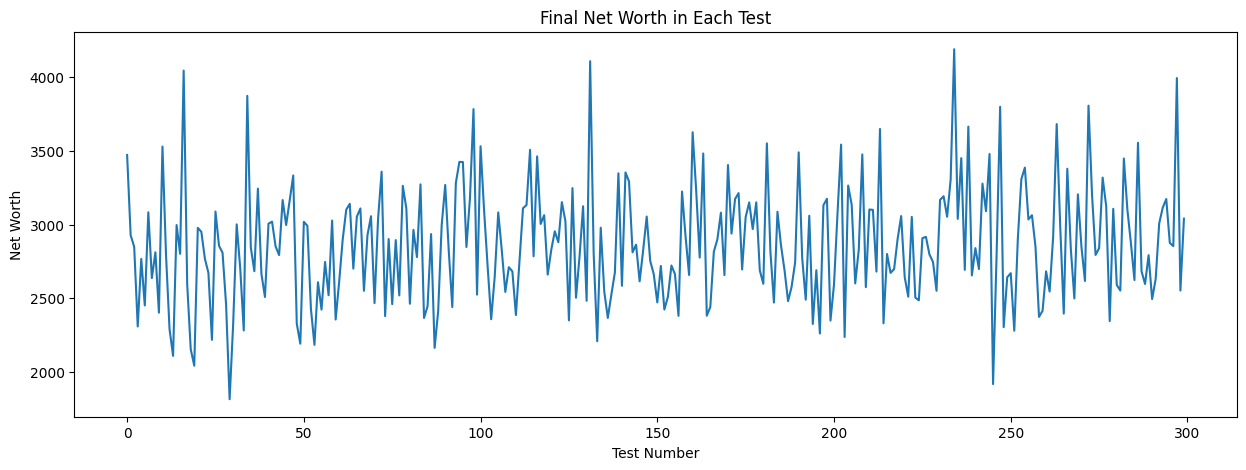

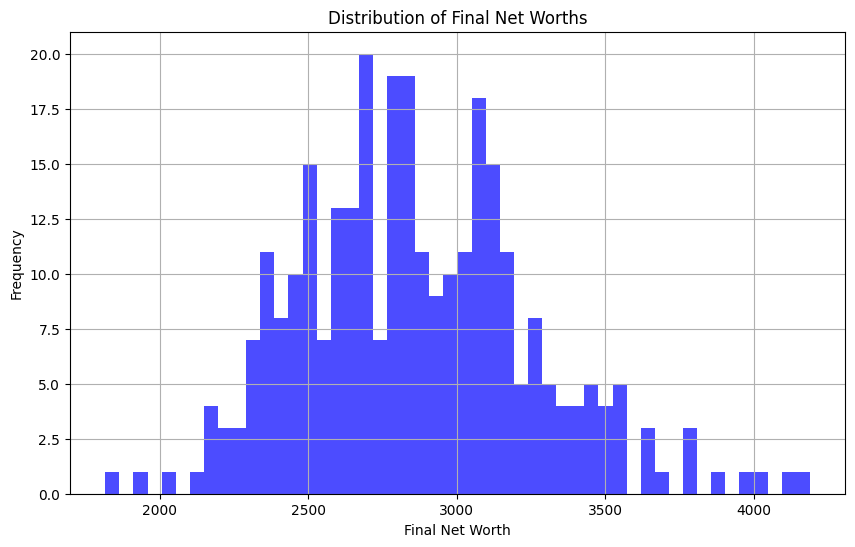

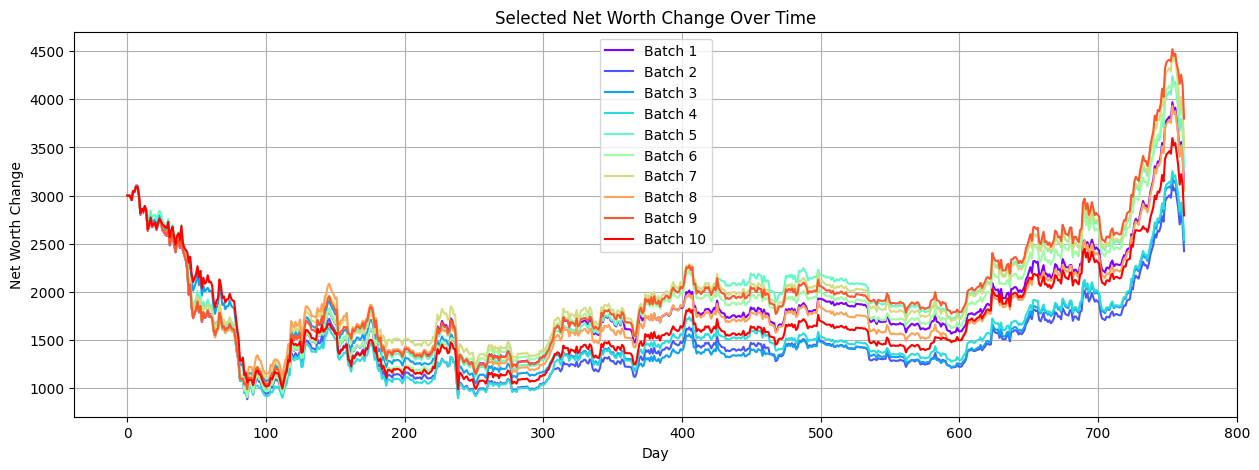

In [17]:
### import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []

    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

# 假设eth_data已经预处理完毕并加载到这里
# 划分数据集为训练集和测试集
split_index = int(0.6 * len(eth_data))
train_data = eth_data[:split_index]
test_data = eth_data[split_index:]

# 初始化环境
env = CryptoTradingEnv(df=train_data)  # 使用训练数据
state_dim = np.prod(env.observation_space.shape)
action_dim = env.action_space.shape[0]

# 初始化PPO代理
memory = Memory()
ppo_agent = PPO(state_dim, action_dim, lr_actor=1e-4, lr_critic=1e-4, gamma=0.995, K_epochs=4, eps_clip=0.2)

# 询问用户是否加载最优权重
load_weights = input("是否加载最优权重？是请输入1，否请输入0: ")
if load_weights == "1":
    weights_path = 'best_model.pth'  # 确保这是你权重文件的正确路径
    ppo_agent.load_weights(weights_path)
    print("权重加载成功！")
    print(f"加载的模型的Re_Vola_Ratio为: {best_ratio:.2f}")
else:
    print("未加载权重，使用初始模型参数。")

# 训练循环
num_episodes = 300  # 总训练episodes
total_rewards = 0  # 初始化总奖励变量
net_worth_over_episodes = []  # 用于记录每个episode的净值

for episode in range(num_episodes):
    state = env.reset()
    episode_net_worths = [env.initial_balance]  # 记录每步结束后的净值
    episode_returns = []  # 存储每步的回报率
    episode_rewards = 0  # 本轮的奖励

    while True:
        action = ppo_agent.select_action(state, memory)
        next_state, reward, done, _ = env.step(action)
        episode_net_worths.append(env.net_worth)  # 更新每步后的净值
        state = next_state
        episode_rewards += reward  # 累计本轮奖励
        memory.rewards.append(reward)

        if len(episode_net_worths) > 1:
            # 计算最新两步之间的回报率
            recent_return = (episode_net_worths[-1] - episode_net_worths[-2]) / episode_net_worths[-2]
            episode_returns.append(recent_return)  # 添加到回报率列表中

        if done:
            # 如果 episode_returns 至少有两个值，计算波动率
            if len(episode_returns) > 1:
                return_volatility = np.std(episode_returns)
            else:
                return_volatility = 0  # 如果只有一步，则波动率为0

            net_worth_over_episodes.append(env.net_worth)  # 记录净值
            if episode % 100 == 0:
                return_percentage = (env.net_worth - env.initial_balance) / env.initial_balance
                print(f'Episode {episode}, Final Net Worth: {env.net_worth}, Return: {return_percentage:.2%}, Return Volatility: {return_volatility:.6f}, Total Rewards: {episode_rewards:.2f}')
            break

    total_rewards += episode_rewards  # 累计整个训练过程中的奖励
    ppo_agent.update(memory)
    memory.clear()

# 绘制训练集的净值变化图
plt.figure(figsize=(15, 5))
plt.plot(net_worth_over_episodes)
plt.title('Final Net Worth in Each Training Episode')
plt.ylabel('Net Worth')
plt.xlabel('Episode Number')
plt.show()

print('Training completed')

# 测试循环
test_env = CryptoTradingEnv(df=test_data)  # 使用测试数据
test_final_net_worths = []
test_returns = []  # 存储每次测试的回报率
test_volatilities = []  # 存储每次测试的波动率
# 初始化用于绘图的列表
test_net_worth_during_tests = []
num_tests = 300

initial_balance = 3000  # 期初余额
best_ratio = float('-inf')  # 初始化最佳性能比率

for test in range(num_tests):
    test_state = test_env.reset()
    test_net_worths = [test_env.initial_balance]  # 初始化测试的净值列表，首先包括初始余额
    test_daily_returns = []  # 存储每天的回报率
    test_rewards = []  # 存储单次测试中的每步奖励
    total_test_rewards = 0  # 累积本次测试的总奖励

    while True:
        test_action = ppo_agent.select_action(test_state, memory)
        test_state, test_reward, test_done, _ = test_env.step(test_action)
        test_net_worths.append(test_env.net_worth)  # 更新测试净值
        total_test_rewards += test_reward  # 累加奖励
        test_rewards.append(test_reward)

        if len(test_net_worths) > 1:
            # 计算最新两步之间的回报率
            recent_return = (test_net_worths[-1] - test_net_worths[-2]) / test_net_worths[-2]
            test_daily_returns.append(recent_return)  # 添加到回报率列表中

        if test_done:
            final_net_worth = test_env.net_worth
            test_final_net_worths.append(final_net_worth)
            test_return = (final_net_worth - initial_balance) / initial_balance

            # 如果 test_daily_returns 至少有两个值，计算波动率
            if len(test_daily_returns) > 1:
                test_return_volatility = np.std(test_daily_returns)
            else:
                test_return_volatility = 0  # 如果只有一步，则波动率为0

            test_returns.append(test_return)
            test_volatilities.append(test_return_volatility)

            if test % 100 == 0:
                print(f'Test {test}, Final Net Worth: {final_net_worth}, Return: {test_return:.2%}, Return Volatility: {test_return_volatility:.6f}, Total Rewards: {total_test_rewards:.2f}')
            break
    # 测试结束后，将整个测试的净值数据添加到外部列表
    test_net_worth_during_tests.append(test_net_worths)

# 打印测试平均回报率和波动率
print(f'Average Test Return: {np.mean(test_returns):.2%}')
print(f'Average Test Volatility: {np.mean(test_return_volatility):.2f}')
print(f'Re_Vola Ratio: {np.mean(test_returns)/np.mean(test_return_volatility):.2f}')

plt.figure(figsize=(15, 5))
plt.plot(test_final_net_worths)
plt.title('Final Net Worth in Each Test')
plt.ylabel('Net Worth')
plt.xlabel('Test Number')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(test_final_net_worths, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Final Net Worths')
plt.xlabel('Final Net Worth')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#### 绘图
num_lines_to_draw = 10  # 你想要绘制的线条数量
num_tests = len(test_net_worth_during_tests)  # 总测试次数
test_group_size = num_tests // num_lines_to_draw  # 每批测试的大小
# 测试集的实际天数
test_days = len(test_data.index)

# 为每条线选择一个颜色
colors = cm.rainbow(np.linspace(0, 1, num_lines_to_draw))

plt.figure(figsize=(15, 5))

# 随机从每个分组中选择一次测试进行绘制
for i in range(num_lines_to_draw):
    # 计算每批的起始索引
    start_idx = i * test_group_size
    # 选择要绘制的测试索引
    selected_test_idx = np.random.choice(range(start_idx, start_idx + test_group_size))
    selected_net_worths = test_net_worth_during_tests[selected_test_idx]
    # 创建时间序列
    times = np.linspace(0, test_days, len(selected_net_worths))
    plt.plot(times, selected_net_worths, color=colors[i], label=f'Batch {i+1}')

plt.title('Selected Net Worth Change Over Time')
plt.xlabel('Day')
plt.ylabel('Net Worth Change')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# # 假设 close_prices 代表了整个测试期间的每天的收盘价
# close_prices = test_data['Close'].tolist()  # 确保这是正确的调用方式，根据你的 DataFrame
# days = list(range(len(close_prices)))  # 生成天数的列表，用于X轴

# # 绘制收盘价和交易位置的代码
# plt.figure(figsize=(14, 7))
# # 假设您已经有了收盘价列表 close_prices 和对应的天数列表 days
# plt.plot(days, close_prices, label='Close Price', color='gray', alpha=0.8)

# # 假设您的环境对象是 env，并且您已经在其中存储了开仓和平仓的信息
# open_positions = env.open_positions
# close_positions = env.close_positions

# # 绘制开仓位置，这里用绿色上三角表示开仓
# for day, price in open_positions:
#     plt.scatter(day, price, color='green', label='Open Position', marker='^', s=100)

# # 绘制平仓位置，这里用红色下三角表示平仓
# for day, price in close_positions:
#     plt.scatter(day, price, color='red', label='Close Position', marker='v', s=100)

# plt.title('Close Prices and Trade Positions')
# plt.xlabel('Day')
# plt.ylabel('Price')

# # 创建一个图例，每个标签只显示一次
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())

# plt.show()

In [32]:
# 假设的期初账户余额
initial_balance = 3000
# 用于存储每次测试的净值变化百分比
net_worth_changes_percent = []

# 计算每次测试的净值变化百分比
for final_net_worth in test_final_net_worths:
    percent_change = ((final_net_worth - initial_balance) / initial_balance) 
    net_worth_changes_percent.append(percent_change)

# 计算平均回报和波动率
average_return = np.mean(net_worth_changes_percent)
volatility = np.std(net_worth_changes_percent)
Re_Vola_ratio = average_return/volatility

print(f"Average Return: {average_return:.2f}")
print(f"Volatility: {volatility:.2f}")
print(f"Re_Vola_ratio: {Re_Vola_ratio:.2f}")

Average Return: 1.55
Volatility: 0.30
Re_Vola_ratio: 5.10


In [33]:
# 计算日收益率，即今天的价格与昨天价格之比减去1
daily_returns = test_data['Close'].pct_change()

# 丢弃NaN值（由于第一天没有前一天的数据，所以会有一个NaN）
daily_returns = daily_returns.dropna()

# 使用cumprod计算累积回报，然后减去1得到累积回报百分比
cumulative_returns = (1 + daily_returns).cumprod() - 1

# 计算波动率，即日收益率的标准差
volatility = daily_returns.std() * len(test_data) ** 0.5

maen_returns = daily_returns.mean() * len(test_data)

# 打印结果
print("Cumlative Return：", cumulative_returns.iloc[-1])  # 取最后一个值作为整个周期的累积回报
print("Volatility：", volatility)
print("maen returns：", maen_returns)


Cumlative Return： 1.6940280332233058
Volatility： 0.852887726694501
maen returns： 1.35563298517517


In [20]:
# 计算日收益率，即今天的价格与昨天价格之比减去1
daily_returns = train_data['Close'].pct_change()

# 丢弃NaN值（由于第一天没有前一天的数据，所以会有一个NaN）
daily_returns = daily_returns.dropna()

# 使用cumprod计算累积回报，然后减去1得到累积回报百分比
cumulative_returns = (1 + daily_returns).cumprod() - 1

# 计算波动率，即日收益率的标准差
volatility = daily_returns.std() * len(train_data) ** 0.5

maen_returns = daily_returns.mean() * len(train_data)

ShR = maen_returns / volatility

# 打印结果
print("Cumlative Return：", cumulative_returns.iloc[-1])  # 取最后一个值作为整个周期的累积回报
print("Volatility：", volatility)
print("maen returns：", maen_returns)
print("sharp：", ShR)

Cumlative Return： 27.569432895393263
Volatility： 1.591379176580031
maen returns： 4.665112422179851
sharp： 2.9314901758394605
